In [59]:
%matplotlib inline

import unicodedata
import re
import random
import time
import math
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Механизм внимания

In [60]:
def load_data(file_path):
    print("Чтение данных...")

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.read().strip().split('\n')

    pairs = []
    for line in lines:
        parts = line.split('\t')
        if len(parts) >= 2:  
            pairs.append((parts[0], parts[1]))  

    print(f"Загружено {len(pairs)} пар предложений.")
    return pairs

file_path = 'data/rus.txt'  
pairs = load_data(file_path)

print(f"Пример пары: {pairs[0]}")

Чтение данных...
Загружено 496059 пар предложений.
Пример пары: ('Go.', 'Марш!')


In [61]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def prepare_data(pairs):
    input_lang = Lang("eng")
    output_lang = Lang("rus")

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print(f"Словарь английского языка: {input_lang.n_words} слов")
    print(f"Словарь русского языка: {output_lang.n_words} слов")
    return input_lang, output_lang

eng_lang, rus_lang = prepare_data(pairs)

Словарь английского языка: 36669 слов
Словарь русского языка: 105113 слов


In [62]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] + [EOS_token]

def tensorsFromPair(pair):
    input_tensor = torch.tensor(indexesFromSentence(eng_lang, pair[0]), dtype=torch.long, device=device)
    target_tensor = torch.tensor(indexesFromSentence(rus_lang, pair[1]), dtype=torch.long, device=device)
    return (input_tensor, target_tensor)

print("Пример тензоров для пары:")
print(tensorsFromPair(pairs[0]))

Пример тензоров для пары:
(tensor([2, 1]), tensor([2, 1]))


In [63]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f"{m}m {s}s"

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return f"{asMinutes(s)} (- {asMinutes(rs)})"

def showPlot(points):
    plt.figure()
    plt.plot(points)
    plt.xlabel("Итерации")
    plt.ylabel("Потери")
    plt.title("График потерь")
    plt.show()

In [64]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=10):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        if ei < max_length:
            encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden, attn_weights = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        loss += criterion(decoder_output, target_tensor[di].view(1))
        decoder_input = target_tensor[di]  

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [65]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  
    plot_loss_total = 0  

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for _ in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


### Скалярное произведение

In [66]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [67]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

1m 3.1303534507751465s (- 9m 28.17318105697632s) (500 10%) 8.4079
2m 5.382534503936768s (- 8m 21.53013801574707s) (1000 20%) 7.3845
3m 7.292638301849365s (- 7m 17.016156037648557s) (1500 30%) 7.0674
4m 10.302577018737793s (- 6m 15.45386552810669s) (2000 40%) 6.9756
5m 11.799063920974731s (- 5m 11.799063920974731s) (2500 50%) 6.8202
6m 13.467594385147095s (- 4m 8.978396256764768s) (3000 60%) 6.5827
7m 17.49232292175293s (- 3m 7.496709823608398s) (3500 70%) 6.4755
8m 17.720975160598755s (- 2m 4.430243790149689s) (4000 80%) 6.4640
9m 20.00100827217102s (- 1m 2.2223342524633836s) (4500 90%) 6.4365
10m 20.899590492248535s (- 0m 0.0s) (5000 100%) 6.2746


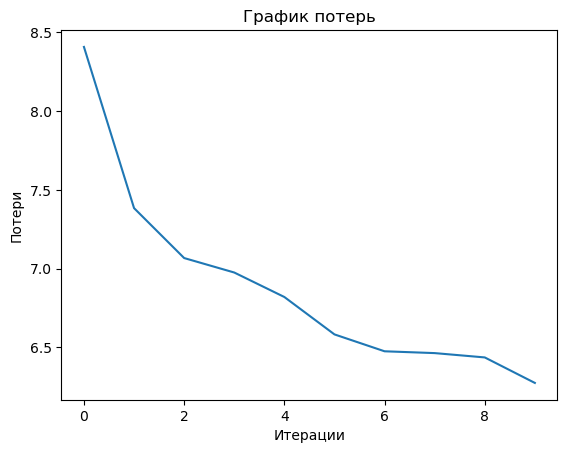

In [68]:
hidden_size = 256
learning_rate = 0.01
n_iters = 5000
print_every = 500
plot_every = 500
max_length = 10  

encoder = EncoderRNN(eng_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, rus_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder, decoder, n_iters=5000, print_every=500, plot_every=500, learning_rate=0.01)

### MLP

In [69]:
class AttnDecoderRNNWithMLP(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNNWithMLP, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Sequential(
            nn.Linear(self.hidden_size * 2, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Compute attention scores using MLP
        attn_energies = []
        for i in range(encoder_outputs.size(0)):
            energy_input = torch.cat((hidden[0], encoder_outputs[i].unsqueeze(0)), dim=1)  # Исправлено
            energy = self.attn(energy_input)  # Pass through MLP
            attn_energies.append(energy)
        attn_energies = torch.cat(attn_energies, dim=0).view(1, -1)  # Reshape to (1, max_length)
        attn_weights = F.softmax(attn_energies, dim=1)

        # Apply attention weights to encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [70]:
hidden_size = 256
encoder = EncoderRNN(eng_lang.n_words, hidden_size).to(device)
decoder_mlp = AttnDecoderRNNWithMLP(hidden_size, rus_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder, decoder_mlp, n_iters=5000, print_every=500, plot_every=500, learning_rate=0.01)

RuntimeError: Tensors must have same number of dimensions: got 2 and 1